## The learning algorithm

This reinforcement learning task was solved using Deep Deterministic Policy Gradient, an algorithm created by OpenAI. DDPG is closely related to Q-learning but adapted for use in continuous spaces. The algorithm utilises innovations from Q-learning such as fixed target and experience replay. The algorithm falls under an umbrella called the Actor-Critic method and consists of 4 networks: actor, critic, target-actor and target-critic. 

The algorithm uses the current actor-network to choose an action a based on input state s, and the environment returns reward r and next_state s’. In the replay buffer, this is stored as an experience tuple, <s,a,r,s’>. The replay buffer is used to break correlations between consecutive experience tuples. The max size is 1e6, and once it is full, the oldest experiences are discarded. Once BATCH_SIZE experiences are in the buffer, the agent begins learning.

The current actor and critic networks are updated as follows:
1) A minibatch of experience tuples is sampled from the replay buffer randomly. 
2) Action a’ is then chosen by the target-actor and evaluated by the target-critic. 
3) This value is then discounted by gamma, added to reward r to from y.
4) The loss is then calculated by the MSE of y, and the expected value of action a calculated by the current critic.
5) This loss is used to update the current critic through backpropagation.
6) We then update the actor-network by taking the derivative of the critic network with respect to the policy parameters, using the mean of the gradients in the mini-batch.

The target networks are just delayed copies of the actor and critic networks, which improves stability as the agent is chasing a much slower-moving target. Every episode, these target networks are updated by a small amount, tau, to match the current actor and critic closely. This project performs a hard update (current weights completely transferred to target weights) every HARD_FREQ, reducing training time without causing any stability issues.


## Hyperparameter Choice

BUFFER_SIZE = int(1e6)
BATCH_SIZE = 512        # chosen to fit in GPU memory   
GAMMA = 0.90           # discount factor   
TAU = 0.5e-3              # low due to addition of hard updates   
LR_ACTOR = 1e-4         # learning rate of the actor    
LR_CRITIC = 1e-4        # learning rate of the critic   
WEIGHT_DECAY = 0        # L2 weight decay   
EPSILON_DEC =0.997   #noise reduction   
TRAIN_FREQ=10     #how often train agent   
HARD_FREQ=100    #how often to perform the hard update   
TRAIN_N=5      #how many times train agent   

Network architecture is the same for all nn was inspired by Gkowalik.   
fc_1 = 350   
fc_2 = 280   

## Enviroment Setup

In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Imports

In [2]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from Agent import Agent

env_info = env.reset(train_mode=True)[brain_name]

agent = Agent(state_size=33, action_size= 4, random_seed=2)

## Training Loop

In [3]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]                   
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="\n")

        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tEnded in episode: {:d}'.format(i_episode-100,i_episode ))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break    
            
    return scores
scores = ddpg()

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Score: 7.97	Average Score: 2.88
Episode 200	Score: 36.53	Average Score: 17.67

Environment solved in 143 episodes!	Ended in episode: 243


## Plot of Rewards
Solved after 243 episodes

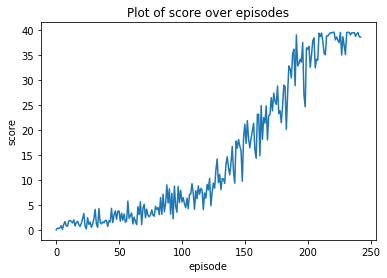

In [9]:
plt.plot(scores)
plt.xlabel('episode')
plt.ylabel('score')
plt.title('Plot of score over episodes')
plt.show()

## Future Improvement

GAMMA, TAU and HARD_FREQ can be tuned further. In addition, it is likely that placing priority on important/rare experience tuple will lead to faster convergence. Alsoa lot more investigation can be done on the exploration vs exploitation front, as adding noise is far more abstract than the epsilon greedy policy used in regular Q-learning. In addition, the Ornstein-Uhlenbeck process may be an overly complex way to add noise, and simpler methods like normally distributed may also work.